# Image Classification
In this project, you'll classify images from the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).  The dataset consists of airplanes, dogs, cats, and other objects. You'll preprocess the images, then train a convolutional neural network on all the samples. The images need to be normalized and the labels need to be one-hot encoded.  You'll get to apply what you learned and build a convolutional, max pooling, dropout, and fully connected layers.  At the end, you'll get to see your neural network's predictions on the sample images.
## Get the Data
Run the following cell to download the [CIFAR-10 dataset for python](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz).

In [1]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import problem_unittests as tests
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

# Use Floyd's cifar-10 dataset if present
floyd_cifar10_location = '/input/cifar-10/python.tar.gz'
if isfile(floyd_cifar10_location):
    tar_gz_path = floyd_cifar10_location
else:
    tar_gz_path = 'cifar-10-python.tar.gz'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(tar_gz_path):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            tar_gz_path,
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open(tar_gz_path) as tar:
        tar.extractall()
        tar.close()


tests.test_folder_path(cifar10_dataset_folder_path)

CIFAR-10 Dataset: 171MB [00:16, 10.2MB/s]                              


All files found!


## Explore the Data
The dataset is broken into batches to prevent your machine from running out of memory.  The CIFAR-10 dataset consists of 5 batches, named `data_batch_1`, `data_batch_2`, etc.. Each batch contains the labels and images that are one of the following:
* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck

Understanding a dataset is part of making predictions on the data.  Play around with the code cell below by changing the `batch_id` and `sample_id`. The `batch_id` is the id for a batch (1-5). The `sample_id` is the id for a image and label pair in the batch.

Ask yourself "What are all possible labels?", "What is the range of values for the image data?", "Are the labels in order or random?".  Answers to questions like these will help you preprocess the data and end up with better predictions.

/usr/local/lib/python3.5/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '



Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 5:
Image - Min Value: 0 Max Value: 252
Image - Shape: (32, 32, 3)
Label - Label Id: 1 Name: automobile


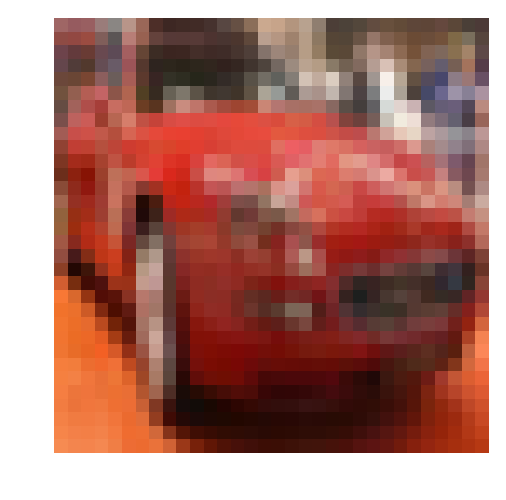

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np

# Explore the dataset
batch_id = 1
sample_id = 5
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

## Implement Preprocess Functions
### Normalize
In the cell below, implement the `normalize` function to take in image data, `x`, and return it as a normalized Numpy array. The values should be in the range of 0 to 1, inclusive.  The return object should be the same shape as `x`.

In [3]:
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    # TODO: Implement Function
    return (x-np.min(x))/(np.max(x)-np.min(x))


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_normalize(normalize)

Tests Passed


### One-hot encode
Just like the previous code cell, you'll be implementing a function for preprocessing.  This time, you'll implement the `one_hot_encode` function. The input, `x`, are a list of labels.  Implement the function to return the list of labels as One-Hot encoded Numpy array.  The possible values for labels are 0 to 9. The one-hot encoding function should return the same encoding for each value between each call to `one_hot_encode`.  Make sure to save the map of encodings outside the function.

Hint: Don't reinvent the wheel.

In [4]:
from sklearn import preprocessing
encoder = None
def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    # TODO: Implement Function
    global encoder
    if encoder is None:
        encoder = preprocessing.LabelBinarizer().fit(x)
    return encoder.transform(x)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_one_hot_encode(one_hot_encode)

Tests Passed


### Randomize Data
As you saw from exploring the data above, the order of the samples are randomized.  It doesn't hurt to randomize it again, but you don't need to for this dataset.

## Preprocess all the data and save it
Running the code cell below will preprocess all the CIFAR-10 data and save it to file. The code below also uses 10% of the training data for validation.

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

# Check Point
This is your first checkpoint.  If you ever decide to come back to this notebook or have to restart the notebook, you can start from here.  The preprocessed data has been saved to disk.

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle
import problem_unittests as tests
import helper

# Load the Preprocessed Validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## Build the network
For the neural network, you'll build each layer into a function.  Most of the code you've seen has been outside of functions. To test your code more thoroughly, we require that you put each layer in a function.  This allows us to give you better feedback and test for simple mistakes using our unittests before you submit your project.

>**Note:** If you're finding it hard to dedicate enough time for this course each week, we've provided a small shortcut to this part of the project. In the next couple of problems, you'll have the option to use classes from the [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages to build each layer, except the layers you build in the "Convolutional and Max Pooling Layer" section.  TF Layers is similar to Keras's and TFLearn's abstraction to layers, so it's easy to pickup.

>However, if you would like to get the most out of this course, try to solve all the problems _without_ using anything from the TF Layers packages. You **can** still use classes from other packages that happen to have the same name as ones you find in TF Layers! For example, instead of using the TF Layers version of the `conv2d` class, [tf.layers.conv2d](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d), you would want to use the TF Neural Network version of `conv2d`, [tf.nn.conv2d](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d). 

Let's begin!

### Input
The neural network needs to read the image data, one-hot encoded labels, and dropout keep probability. Implement the following functions
* Implement `neural_net_image_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)
 * Set the shape using `image_shape` with batch size set to `None`.
 * Name the TensorFlow placeholder "x" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).
* Implement `neural_net_label_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)
 * Set the shape using `n_classes` with batch size set to `None`.
 * Name the TensorFlow placeholder "y" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).
* Implement `neural_net_keep_prob_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder) for dropout keep probability.
 * Name the TensorFlow placeholder "keep_prob" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).

These names will be used at the end of the project to load your saved model.

Note: `None` for shapes in TensorFlow allow for a dynamic size.

In [7]:
import tensorflow as tf

def neural_net_image_input(image_shape):
    """
    Return a Tensor for a batch of image input
    : image_shape: Shape of the images
    : return: Tensor for image input.
    """
    # TODO: Implement Function
    return tf.placeholder(dtype=tf.float32,shape=[None]+list(image_shape),name='x')


def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """
    # TODO: Implement Function
    return tf.placeholder(dtype=tf.float32,shape=[None]+[n_classes],name='y')


def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    # TODO: Implement Function
    return tf.placeholder(dtype=tf.float32,name='keep_prob')


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tf.reset_default_graph()
tests.test_nn_image_inputs(neural_net_image_input)
tests.test_nn_label_inputs(neural_net_label_input)
tests.test_nn_keep_prob_inputs(neural_net_keep_prob_input)

Image Input Tests Passed.
Label Input Tests Passed.
Keep Prob Tests Passed.


### Convolution and Max Pooling Layer
Convolution layers have a lot of success with images. For this code cell, you should implement the function `conv2d_maxpool` to apply convolution then max pooling:
* Create the weight and bias using `conv_ksize`, `conv_num_outputs` and the shape of `x_tensor`.
* Apply a convolution to `x_tensor` using weight and `conv_strides`.
 * We recommend you use same padding, but you're welcome to use any padding.
* Add bias
* Add a nonlinear activation to the convolution.
* Apply Max Pooling using `pool_ksize` and `pool_strides`.
 * We recommend you use same padding, but you're welcome to use any padding.

**Note:** You **can't** use [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) for **this** layer, but you can still use TensorFlow's [Neural Network](https://www.tensorflow.org/api_docs/python/tf/nn) package. You may still use the shortcut option for all the **other** layers.

In [8]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    # TODO: Implement Function
    input_depth = int(x_tensor.get_shape()[3])
    weight = tf.Variable(tf.truncated_normal([*conv_ksize,input_depth,conv_num_outputs]))
    bias = tf.Variable(tf.zeros(conv_num_outputs))
    # Apply Convolution
    conv_layer = tf.nn.conv2d(x_tensor, weight, strides=[1,*conv_strides,1], padding='SAME')
    # Add bias
    conv_layer = tf.nn.bias_add(conv_layer, bias)
    # Apply activation function
    conv_layer = tf.nn.relu(conv_layer)
    # Apply Max Pooling
    conv_layer = tf.nn.max_pool(
    conv_layer,
    ksize=[1,*pool_ksize,1],
    strides=[1,*pool_strides,1],
    padding='SAME')
    return conv_layer 


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_con_pool(conv2d_maxpool)

Tests Passed


### Flatten Layer
Implement the `flatten` function to change the dimension of `x_tensor` from a 4-D tensor to a 2-D tensor.  The output should be the shape (*Batch Size*, *Flattened Image Size*). Shortcut option: you can use classes from the [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages for this layer. For more of a challenge, only use other TensorFlow packages.

In [9]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    # TODO: Implement Function
    return tf.contrib.layers.flatten(x_tensor)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_flatten(flatten)

Tests Passed


### Fully-Connected Layer
Implement the `fully_conn` function to apply a fully connected layer to `x_tensor` with the shape (*Batch Size*, *num_outputs*). Shortcut option: you can use classes from the [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages for this layer. For more of a challenge, only use other TensorFlow packages.

In [10]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # TODO: Implement Function
    weight = tf.Variable(tf.truncated_normal([int(x_tensor.shape[1]), num_outputs]))
    bias = tf.Variable(tf.random_normal([num_outputs]))
    
    # fully connected layer
    fully_conn_layer = tf.add(tf.matmul(x_tensor, weight), bias)
    return fully_conn_layer


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_fully_conn(fully_conn)

Tests Passed


### Output Layer
Implement the `output` function to apply a fully connected layer to `x_tensor` with the shape (*Batch Size*, *num_outputs*). Shortcut option: you can use classes from the [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages for this layer. For more of a challenge, only use other TensorFlow packages.

**Note:** Activation, softmax, or cross entropy should **not** be applied to this.

In [11]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # TODO: Implement Function
    weight = tf.Variable(tf.truncated_normal([int(x_tensor.shape[1]), num_outputs]))
    bias = tf.Variable(tf.random_normal([num_outputs]))
    
    # fully connected layer
    output_layer = tf.add(tf.matmul(x_tensor, weight), bias)
    return output_layer


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_output(output)

Tests Passed


### Create Convolutional Model
Implement the function `conv_net` to create a convolutional neural network model. The function takes in a batch of images, `x`, and outputs logits.  Use the layers you created above to create this model:

* Apply 1, 2, or 3 Convolution and Max Pool layers
* Apply a Flatten Layer
* Apply 1, 2, or 3 Fully Connected Layers
* Apply an Output Layer
* Return the output
* Apply [TensorFlow's Dropout](https://www.tensorflow.org/api_docs/python/tf/nn/dropout) to one or more layers in the model using `keep_prob`. 

In [12]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    # TODO: Apply 1, 2, or 3 Convolution and Max Pool layers
    #    Play around with different number of outputs, kernel size and stride
    # Function Definition from Above:
    #    conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides)
    x_tensor = x
    conv_num_outputs = 128
    conv_ksize = (3,3)
    conv_strides = (2,2)
    pool_ksize = (4,4)
    pool_strides = (1,1)
    num_outputs = 10
    
    conv2d_maxpool_layer = conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides)
    

    # TODO: Apply a Flatten Layer
    # Function Definition from Above:
    #   flatten(x_tensor)
    flattened_layer = flatten(conv2d_maxpool_layer)
    

    # TODO: Apply 1, 2, or 3 Fully Connected Layers
    #    Play around with different number of outputs
    # Function Definition from Above:
    #   fully_conn(x_tensor, num_outputs)
    fully_conn_layer = fully_conn(flattened_layer, num_outputs)
    fully_conn_layer = tf.nn.dropout(fully_conn_layer, keep_prob)
    # TODO: Apply an Output Layer
    #    Set this to the number of classes
    # Function Definition from Above:
    #   output(x_tensor, num_outputs)
    output_layer = output(fully_conn_layer, num_outputs)
    
    # TODO: return output
    return output_layer

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

##############################
## Build the Neural Network ##
##############################

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

tests.test_conv_net(conv_net)

Neural Network Built!


## Train the Neural Network
### Single Optimization
Implement the function `train_neural_network` to do a single optimization.  The optimization should use `optimizer` to optimize in `session` with a `feed_dict` of the following:
* `x` for image input
* `y` for labels
* `keep_prob` for keep probability for dropout

This function will be called for each batch, so `tf.global_variables_initializer()` has already been called.

Note: Nothing needs to be returned. This function is only optimizing the neural network.

In [13]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    # TODO: Implement Function
    session.run(optimizer, feed_dict={x:feature_batch,y:label_batch,keep_prob:keep_probability})



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_train_nn(train_neural_network)

Tests Passed


### Show Stats
Implement the function `print_stats` to print loss and validation accuracy.  Use the global variables `valid_features` and `valid_labels` to calculate validation accuracy.  Use a keep probability of `1.0` to calculate the loss and validation accuracy.

In [16]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    # TODO: Implement Function
    loss = session.run(cost, feed_dict={x:feature_batch, y:label_batch, keep_prob:1.0})
    validation_accuracy = session.run(accuracy, feed_dict={x:valid_features, y:valid_labels, keep_prob:1.0})
    print('Loss: ',loss, 'Accuracy: ',validation_accuracy)

### Hyperparameters
Tune the following parameters:
* Set `epochs` to the number of iterations until the network stops learning or start overfitting
* Set `batch_size` to the highest number that your machine has memory for.  Most people set them to common sizes of memory:
 * 64
 * 128
 * 256
 * ...
* Set `keep_probability` to the probability of keeping a node using dropout

In [ ]:
# TODO: Tune Parameters
epochs = 300
batch_size = 128
keep_probability = 0.5

### Train on a Single CIFAR-10 Batch
Instead of training the neural network on all the CIFAR-10 batches of data, let's use a single batch. This should save time while you iterate on the model to get a better accuracy.  Once the final validation accuracy is 50% or greater, run the model on all the data in the next section.

In [ ]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)

Checking the Training on a Single Batch...
Epoch  1, CIFAR-10 Batch 1:  Loss:  282.459 Accuracy:  0.1444
Epoch  2, CIFAR-10 Batch 1:  Loss:  212.774 Accuracy:  0.182
Epoch  3, CIFAR-10 Batch 1:  Loss:  184.308 Accuracy:  0.2084
Epoch  4, CIFAR-10 Batch 1:  Loss:  148.722 Accuracy:  0.2286
Epoch  5, CIFAR-10 Batch 1:  Loss:  121.179 Accuracy:  0.2422
Epoch  6, CIFAR-10 Batch 1:  Loss:  116.594 Accuracy:  0.259
Epoch  7, CIFAR-10 Batch 1:  Loss:  92.214 Accuracy:  0.2614
Epoch  8, CIFAR-10 Batch 1:  Loss:  87.0262 Accuracy:  0.2522
Epoch  9, CIFAR-10 Batch 1:  Loss:  73.1058 Accuracy:  0.2768
Epoch 10, CIFAR-10 Batch 1:  Loss:  67.1735 Accuracy:  0.2776
Epoch 11, CIFAR-10 Batch 1:  Loss:  62.4125 Accuracy:  0.3032
Epoch 12, CIFAR-10 Batch 1:  Loss:  54.4072 Accuracy:  0.294
Epoch 13, CIFAR-10 Batch 1:  Loss:  52.9467 Accuracy:  0.3002
Epoch 14, CIFAR-10 Batch 1:  Loss:  48.0513 Accuracy:  0.3206
Epoch 15, CIFAR-10 Batch 1:  Loss:  41.752 Accuracy:  0.3144
Epoch 16, CIFAR-10 Batch 1:  Los

Epoch 133, CIFAR-10 Batch 1:  Loss:  1.18182 Accuracy:  0.4654
Epoch 134, CIFAR-10 Batch 1:  Loss:  1.15549 Accuracy:  0.4642
Epoch 135, CIFAR-10 Batch 1:  Loss:  1.19762 Accuracy:  0.466
Epoch 136, CIFAR-10 Batch 1:  Loss:  1.22506 Accuracy:  0.4658
Epoch 137, CIFAR-10 Batch 1:  Loss:  1.24141 Accuracy:  0.465
Epoch 138, CIFAR-10 Batch 1:  Loss:  1.1831 Accuracy:  0.464
Epoch 139, CIFAR-10 Batch 1:  Loss:  1.24674 Accuracy:  0.4676
Epoch 140, CIFAR-10 Batch 1:  Loss:  1.16922 Accuracy:  0.4746
Epoch 141, CIFAR-10 Batch 1:  Loss:  1.16703 Accuracy:  0.4782
Epoch 142, CIFAR-10 Batch 1:  Loss:  1.16183 Accuracy:  0.4834
Epoch 143, CIFAR-10 Batch 1:  Loss:  1.15341 Accuracy:  0.4888
Epoch 144, CIFAR-10 Batch 1:  Loss:  1.18193 Accuracy:  0.4838
Epoch 145, CIFAR-10 Batch 1:  Loss:  1.17506 Accuracy:  0.4838
Epoch 146, CIFAR-10 Batch 1:  Loss:  1.12474 Accuracy:  0.4788
Epoch 147, CIFAR-10 Batch 1:  Loss:  1.12069 Accuracy:  0.492
Epoch 148, CIFAR-10 Batch 1:  Loss:  1.07639 Accuracy:  0.49

Epoch 263, CIFAR-10 Batch 1:  Loss:  0.45954 Accuracy:  0.5446
Epoch 264, CIFAR-10 Batch 1:  Loss:  0.434342 Accuracy:  0.5378
Epoch 265, CIFAR-10 Batch 1:  Loss:  0.455279 Accuracy:  0.5336
Epoch 266, CIFAR-10 Batch 1:  Loss:  0.435649 Accuracy:  0.5434
Epoch 267, CIFAR-10 Batch 1:  Loss:  0.428076 Accuracy:  0.5382
Epoch 268, CIFAR-10 Batch 1:  Loss:  0.435455 Accuracy:  0.5332
Epoch 269, CIFAR-10 Batch 1:  Loss:  0.419451 Accuracy:  0.5326
Epoch 270, CIFAR-10 Batch 1:  Loss:  0.407256 Accuracy:  0.533
Epoch 271, CIFAR-10 Batch 1:  Loss:  0.41034 Accuracy:  0.5182
Epoch 272, CIFAR-10 Batch 1:  Loss:  0.429718 Accuracy:  0.5332
Epoch 273, CIFAR-10 Batch 1:  Loss:  0.42342 Accuracy:  0.5358
Epoch 274, CIFAR-10 Batch 1:  Loss:  0.417269 Accuracy:  0.536
Epoch 275, CIFAR-10 Batch 1:  Loss:  0.39901 Accuracy:  0.534
Epoch 276, CIFAR-10 Batch 1:  Loss:  0.408296 Accuracy:  0.5344
Epoch 277, CIFAR-10 Batch 1:  Loss:  0.391245 Accuracy:  0.5438
Epoch 278, CIFAR-10 Batch 1:  Loss:  0.422907 A

### Fully Train the Model
Now that you got a good accuracy with a single CIFAR-10 batch, try it with all five batches.

In [ ]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  Loss:  231.632 Accuracy:  0.1522
Epoch  1, CIFAR-10 Batch 2:  Loss:  179.066 Accuracy:  0.1838
Epoch  1, CIFAR-10 Batch 3:  Loss:  143.778 Accuracy:  0.2096
Epoch  1, CIFAR-10 Batch 4:  Loss:  96.8516 Accuracy:  0.2234
Epoch  1, CIFAR-10 Batch 5:  Loss:  111.07 Accuracy:  0.2386
Epoch  2, CIFAR-10 Batch 1:  Loss:  100.811 Accuracy:  0.227
Epoch  2, CIFAR-10 Batch 2:  Loss:  86.9052 Accuracy:  0.256
Epoch  2, CIFAR-10 Batch 3:  Loss:  76.1488 Accuracy:  0.2678
Epoch  2, CIFAR-10 Batch 4:  Loss:  57.2585 Accuracy:  0.2648
Epoch  2, CIFAR-10 Batch 5:  Loss:  75.8445 Accuracy:  0.2714
Epoch  3, CIFAR-10 Batch 1:  Loss:  64.8666 Accuracy:  0.27
Epoch  3, CIFAR-10 Batch 2:  Loss:  51.3847 Accuracy:  0.276
Epoch  3, CIFAR-10 Batch 3:  Loss:  47.1565 Accuracy:  0.2966
Epoch  3, CIFAR-10 Batch 4:  Loss:  42.6438 Accuracy:  0.311
Epoch  3, CIFAR-10 Batch 5:  Loss:  49.7247 Accuracy:  0.3036
Epoch  4, CIFAR-10 Batch 1:  Loss:  43.5724 Accuracy:  0.3002
Epo

Epoch 27, CIFAR-10 Batch 4:  Loss:  1.38575 Accuracy:  0.4674
Epoch 27, CIFAR-10 Batch 5:  Loss:  1.44991 Accuracy:  0.4538
Epoch 28, CIFAR-10 Batch 1:  Loss:  1.61367 Accuracy:  0.4782
Epoch 28, CIFAR-10 Batch 2:  Loss:  1.39778 Accuracy:  0.4594
Epoch 28, CIFAR-10 Batch 3:  Loss:  1.29948 Accuracy:  0.4664
Epoch 28, CIFAR-10 Batch 4:  Loss:  1.32155 Accuracy:  0.4854
Epoch 28, CIFAR-10 Batch 5:  Loss:  1.41859 Accuracy:  0.4626
Epoch 29, CIFAR-10 Batch 1:  Loss:  1.60005 Accuracy:  0.4766
Epoch 29, CIFAR-10 Batch 2:  Loss:  1.38735 Accuracy:  0.4726
Epoch 29, CIFAR-10 Batch 3:  Loss:  1.23365 Accuracy:  0.4928
Epoch 29, CIFAR-10 Batch 4:  Loss:  1.36032 Accuracy:  0.4924
Epoch 29, CIFAR-10 Batch 5:  Loss:  1.40295 Accuracy:  0.4656
Epoch 30, CIFAR-10 Batch 1:  Loss:  1.60233 Accuracy:  0.4944
Epoch 30, CIFAR-10 Batch 2:  Loss:  1.32951 Accuracy:  0.4948
Epoch 30, CIFAR-10 Batch 3:  Loss:  1.22326 Accuracy:  0.4724
Epoch 30, CIFAR-10 Batch 4:  Loss:  1.36723 Accuracy:  0.4814
Epoch 30

Epoch 54, CIFAR-10 Batch 2:  Loss:  0.907216 Accuracy:  0.5868
Epoch 54, CIFAR-10 Batch 3:  Loss:  0.77819 Accuracy:  0.5768
Epoch 54, CIFAR-10 Batch 4:  Loss:  1.05099 Accuracy:  0.5802
Epoch 54, CIFAR-10 Batch 5:  Loss:  0.968666 Accuracy:  0.5694
Epoch 55, CIFAR-10 Batch 1:  Loss:  1.01582 Accuracy:  0.586
Epoch 55, CIFAR-10 Batch 2:  Loss:  0.921005 Accuracy:  0.591
Epoch 55, CIFAR-10 Batch 3:  Loss:  0.783417 Accuracy:  0.5976
Epoch 55, CIFAR-10 Batch 4:  Loss:  1.11793 Accuracy:  0.5526
Epoch 55, CIFAR-10 Batch 5:  Loss:  0.959995 Accuracy:  0.5902
Epoch 56, CIFAR-10 Batch 1:  Loss:  1.01425 Accuracy:  0.5888
Epoch 56, CIFAR-10 Batch 2:  Loss:  0.952394 Accuracy:  0.5836
Epoch 56, CIFAR-10 Batch 3:  Loss:  0.780906 Accuracy:  0.5894
Epoch 56, CIFAR-10 Batch 4:  Loss:  1.03708 Accuracy:  0.5846
Epoch 56, CIFAR-10 Batch 5:  Loss:  0.99995 Accuracy:  0.5628
Epoch 57, CIFAR-10 Batch 1:  Loss:  0.994545 Accuracy:  0.5938
Epoch 57, CIFAR-10 Batch 2:  Loss:  0.895785 Accuracy:  0.59
Epo

Epoch 80, CIFAR-10 Batch 3:  Loss:  0.593234 Accuracy:  0.624
Epoch 80, CIFAR-10 Batch 4:  Loss:  0.773718 Accuracy:  0.618
Epoch 80, CIFAR-10 Batch 5:  Loss:  0.763771 Accuracy:  0.6208
Epoch 81, CIFAR-10 Batch 1:  Loss:  0.782322 Accuracy:  0.6158
Epoch 81, CIFAR-10 Batch 2:  Loss:  0.733394 Accuracy:  0.6042
Epoch 81, CIFAR-10 Batch 3:  Loss:  0.628434 Accuracy:  0.6144
Epoch 81, CIFAR-10 Batch 4:  Loss:  0.804591 Accuracy:  0.611
Epoch 81, CIFAR-10 Batch 5:  Loss:  0.766199 Accuracy:  0.5932
Epoch 82, CIFAR-10 Batch 1:  Loss:  0.823805 Accuracy:  0.6106
Epoch 82, CIFAR-10 Batch 2:  Loss:  0.721574 Accuracy:  0.6178
Epoch 82, CIFAR-10 Batch 3:  Loss:  0.59795 Accuracy:  0.6038
Epoch 82, CIFAR-10 Batch 4:  Loss:  0.809557 Accuracy:  0.6064
Epoch 82, CIFAR-10 Batch 5:  Loss:  0.715672 Accuracy:  0.6168
Epoch 83, CIFAR-10 Batch 1:  Loss:  0.772074 Accuracy:  0.6252
Epoch 83, CIFAR-10 Batch 2:  Loss:  0.704746 Accuracy:  0.6188
Epoch 83, CIFAR-10 Batch 3:  Loss:  0.613132 Accuracy:  0.6

Epoch 106, CIFAR-10 Batch 4:  Loss:  0.6248 Accuracy:  0.6212
Epoch 106, CIFAR-10 Batch 5:  Loss:  0.581441 Accuracy:  0.6206
Epoch 107, CIFAR-10 Batch 1:  Loss:  0.654932 Accuracy:  0.6164
Epoch 107, CIFAR-10 Batch 2:  Loss:  0.549161 Accuracy:  0.6202
Epoch 107, CIFAR-10 Batch 3:  Loss:  0.485644 Accuracy:  0.6276
Epoch 107, CIFAR-10 Batch 4:  Loss:  0.579549 Accuracy:  0.6238
Epoch 107, CIFAR-10 Batch 5:  Loss:  0.579959 Accuracy:  0.614
Epoch 108, CIFAR-10 Batch 1:  Loss:  0.675554 Accuracy:  0.6208
Epoch 108, CIFAR-10 Batch 2:  Loss:  0.525134 Accuracy:  0.634
Epoch 108, CIFAR-10 Batch 3:  Loss:  0.512795 Accuracy:  0.6204
Epoch 108, CIFAR-10 Batch 4:  Loss:  0.604498 Accuracy:  0.628
Epoch 108, CIFAR-10 Batch 5:  Loss:  0.633324 Accuracy:  0.613
Epoch 109, CIFAR-10 Batch 1:  Loss:  0.634674 Accuracy:  0.6096
Epoch 109, CIFAR-10 Batch 2:  Loss:  0.547529 Accuracy:  0.6216
Epoch 109, CIFAR-10 Batch 3:  Loss:  0.452063 Accuracy:  0.6286
Epoch 109, CIFAR-10 Batch 4:  Loss:  0.592052 

Epoch 132, CIFAR-10 Batch 3:  Loss:  0.375046 Accuracy:  0.6226
Epoch 132, CIFAR-10 Batch 4:  Loss:  0.48674 Accuracy:  0.6338
Epoch 132, CIFAR-10 Batch 5:  Loss:  0.498892 Accuracy:  0.6302
Epoch 133, CIFAR-10 Batch 1:  Loss:  0.518865 Accuracy:  0.6316
Epoch 133, CIFAR-10 Batch 2:  Loss:  0.431279 Accuracy:  0.6406
Epoch 133, CIFAR-10 Batch 3:  Loss:  0.381698 Accuracy:  0.6394
Epoch 133, CIFAR-10 Batch 4:  Loss:  0.491649 Accuracy:  0.6252
Epoch 133, CIFAR-10 Batch 5:  Loss:  0.465872 Accuracy:  0.6362
Epoch 134, CIFAR-10 Batch 1:  Loss:  0.504797 Accuracy:  0.637
Epoch 134, CIFAR-10 Batch 2:  Loss:  0.434529 Accuracy:  0.6302
Epoch 134, CIFAR-10 Batch 3:  Loss:  0.398492 Accuracy:  0.6294
Epoch 134, CIFAR-10 Batch 4:  Loss:  0.483582 Accuracy:  0.6334
Epoch 134, CIFAR-10 Batch 5:  Loss:  0.547055 Accuracy:  0.6066
Epoch 135, CIFAR-10 Batch 1:  Loss:  0.517484 Accuracy:  0.6344
Epoch 135, CIFAR-10 Batch 2:  Loss:  0.459214 Accuracy:  0.6246
Epoch 135, CIFAR-10 Batch 3:  Loss:  0.383

Epoch 158, CIFAR-10 Batch 2:  Loss:  0.371246 Accuracy:  0.6322
Epoch 158, CIFAR-10 Batch 3:  Loss:  0.324987 Accuracy:  0.6364
Epoch 158, CIFAR-10 Batch 4:  Loss:  0.431707 Accuracy:  0.6298
Epoch 158, CIFAR-10 Batch 5:  Loss:  0.442245 Accuracy:  0.611
Epoch 159, CIFAR-10 Batch 1:  Loss:  0.451753 Accuracy:  0.637
Epoch 159, CIFAR-10 Batch 2:  Loss:  0.375551 Accuracy:  0.6326
Epoch 159, CIFAR-10 Batch 3:  Loss:  0.333409 Accuracy:  0.6372
Epoch 159, CIFAR-10 Batch 4:  Loss:  0.385398 Accuracy:  0.6304
Epoch 159, CIFAR-10 Batch 5:  Loss:  0.398795 Accuracy:  0.6042
Epoch 160, CIFAR-10 Batch 1:  Loss:  0.409788 Accuracy:  0.6252
Epoch 160, CIFAR-10 Batch 2:  Loss:  0.389605 Accuracy:  0.6318
Epoch 160, CIFAR-10 Batch 3:  Loss:  0.298325 Accuracy:  0.6348
Epoch 160, CIFAR-10 Batch 4:  Loss:  0.388055 Accuracy:  0.627
Epoch 160, CIFAR-10 Batch 5:  Loss:  0.410225 Accuracy:  0.6328
Epoch 161, CIFAR-10 Batch 1:  Loss:  0.40523 Accuracy:  0.6306
Epoch 161, CIFAR-10 Batch 2:  Loss:  0.38658

Epoch 185, CIFAR-10 Batch 1:  Loss:  0.344037 Accuracy:  0.6284
Epoch 185, CIFAR-10 Batch 2:  Loss:  0.304156 Accuracy:  0.6336
Epoch 185, CIFAR-10 Batch 3:  Loss:  0.252749 Accuracy:  0.6264
Epoch 185, CIFAR-10 Batch 4:  Loss:  0.352166 Accuracy:  0.6186
Epoch 185, CIFAR-10 Batch 5:  Loss:  0.36783 Accuracy:  0.6314
Epoch 186, CIFAR-10 Batch 1:  Loss:  0.394068 Accuracy:  0.627
Epoch 186, CIFAR-10 Batch 2:  Loss:  0.306657 Accuracy:  0.6228
Epoch 186, CIFAR-10 Batch 3:  Loss:  0.267203 Accuracy:  0.6352
Epoch 186, CIFAR-10 Batch 4:  Loss:  0.34173 Accuracy:  0.6258
Epoch 186, CIFAR-10 Batch 5:  Loss:  0.369636 Accuracy:  0.6244
Epoch 187, CIFAR-10 Batch 1:  Loss:  0.373078 Accuracy:  0.6204
Epoch 187, CIFAR-10 Batch 2:  Loss:  0.319092 Accuracy:  0.633
Epoch 187, CIFAR-10 Batch 3:  Loss:  0.268459 Accuracy:  0.6314
Epoch 187, CIFAR-10 Batch 4:  Loss:  0.342021 Accuracy:  0.6248
Epoch 187, CIFAR-10 Batch 5:  Loss:  0.351993 Accuracy:  0.6204
Epoch 188, CIFAR-10 Batch 1:  Loss:  0.36229

Epoch 210, CIFAR-10 Batch 5:  Loss:  0.311729 Accuracy:  0.625
Epoch 211, CIFAR-10 Batch 1:  Loss:  0.309636 Accuracy:  0.6334
Epoch 211, CIFAR-10 Batch 2:  Loss:  0.28415 Accuracy:  0.6306
Epoch 211, CIFAR-10 Batch 3:  Loss:  0.215004 Accuracy:  0.634
Epoch 211, CIFAR-10 Batch 4:  Loss:  0.277807 Accuracy:  0.633
Epoch 211, CIFAR-10 Batch 5:  Loss:  0.310492 Accuracy:  0.6276
Epoch 212, CIFAR-10 Batch 1:  Loss:  0.338867 Accuracy:  0.636
Epoch 212, CIFAR-10 Batch 2:  Loss:  0.260069 Accuracy:  0.636
Epoch 212, CIFAR-10 Batch 3:  Loss:  0.223327 Accuracy:  0.642
Epoch 212, CIFAR-10 Batch 4:  Loss:  0.298356 Accuracy:  0.6274
Epoch 212, CIFAR-10 Batch 5:  Loss:  0.29111 Accuracy:  0.6196
Epoch 213, CIFAR-10 Batch 1:  Loss:  0.295564 Accuracy:  0.6316
Epoch 213, CIFAR-10 Batch 2:  Loss:  0.242964 Accuracy:  0.633
Epoch 213, CIFAR-10 Batch 3:  Loss:  0.236582 Accuracy:  0.6236
Epoch 213, CIFAR-10 Batch 4:  Loss:  0.282883 Accuracy:  0.631
Epoch 213, CIFAR-10 Batch 5:  Loss:  0.284997 Accu

Epoch 236, CIFAR-10 Batch 4:  Loss:  0.303108 Accuracy:  0.6172
Epoch 236, CIFAR-10 Batch 5:  Loss:  0.255741 Accuracy:  0.6256
Epoch 237, CIFAR-10 Batch 1:  Loss:  0.277551 Accuracy:  0.628
Epoch 237, CIFAR-10 Batch 2:  Loss:  0.220195 Accuracy:  0.6268
Epoch 237, CIFAR-10 Batch 3:  Loss:  0.196462 Accuracy:  0.6314
Epoch 237, CIFAR-10 Batch 4:  Loss:  0.243891 Accuracy:  0.6328
Epoch 237, CIFAR-10 Batch 5:  Loss:  0.266757 Accuracy:  0.6184
Epoch 238, CIFAR-10 Batch 1:  Loss:  0.266835 Accuracy:  0.6252
Epoch 238, CIFAR-10 Batch 2:  Loss:  0.220616 Accuracy:  0.625
Epoch 238, CIFAR-10 Batch 3:  Loss:  0.201887 Accuracy:  0.6272
Epoch 238, CIFAR-10 Batch 4:  Loss:  0.264887 Accuracy:  0.6234
Epoch 238, CIFAR-10 Batch 5:  Loss:  0.254116 Accuracy:  0.6294
Epoch 239, CIFAR-10 Batch 1:  Loss:  0.264612 Accuracy:  0.624
Epoch 239, CIFAR-10 Batch 2:  Loss:  0.22306 Accuracy:  0.6344
Epoch 239, CIFAR-10 Batch 3:  Loss:  0.19371 Accuracy:  0.6294
Epoch 239, CIFAR-10 Batch 4:  Loss:  0.272823

Epoch 262, CIFAR-10 Batch 3:  Loss:  0.178537 Accuracy:  0.6214
Epoch 262, CIFAR-10 Batch 4:  Loss:  0.248843 Accuracy:  0.6134
Epoch 262, CIFAR-10 Batch 5:  Loss:  0.237048 Accuracy:  0.612
Epoch 263, CIFAR-10 Batch 1:  Loss:  0.236876 Accuracy:  0.6112
Epoch 263, CIFAR-10 Batch 2:  Loss:  0.218856 Accuracy:  0.634
Epoch 263, CIFAR-10 Batch 3:  Loss:  0.194617 Accuracy:  0.614
Epoch 263, CIFAR-10 Batch 4:  Loss:  0.219733 Accuracy:  0.6238
Epoch 263, CIFAR-10 Batch 5:  Loss:  0.234553 Accuracy:  0.6208
Epoch 264, CIFAR-10 Batch 1:  Loss:  0.200697 Accuracy:  0.6242
Epoch 264, CIFAR-10 Batch 2:  Loss:  0.196888 Accuracy:  0.6246
Epoch 264, CIFAR-10 Batch 3:  Loss:  0.160383 Accuracy:  0.6226
Epoch 264, CIFAR-10 Batch 4:  Loss:  0.228664 Accuracy:  0.6254
Epoch 264, CIFAR-10 Batch 5:  Loss:  0.220648 Accuracy:  0.6176
Epoch 265, CIFAR-10 Batch 1:  Loss:  0.223699 Accuracy:  0.6194
Epoch 265, CIFAR-10 Batch 2:  Loss:  0.190496 Accuracy:  0.6276
Epoch 265, CIFAR-10 Batch 3:  Loss:  0.1712

Epoch 288, CIFAR-10 Batch 2:  Loss:  0.157281 Accuracy:  0.6246
Epoch 288, CIFAR-10 Batch 3:  Loss:  0.152309 Accuracy:  0.6198
Epoch 288, CIFAR-10 Batch 4:  Loss:  0.216957 Accuracy:  0.623
Epoch 288, CIFAR-10 Batch 5:  Loss:  0.207309 Accuracy:  0.6134
Epoch 289, CIFAR-10 Batch 1:  Loss:  0.225631 Accuracy:  0.5956
Epoch 289, CIFAR-10 Batch 2:  Loss:  0.172211 Accuracy:  0.6202
Epoch 289, CIFAR-10 Batch 3:  Loss:  0.151386 Accuracy:  0.621
Epoch 289, CIFAR-10 Batch 4:  Loss:  0.204979 Accuracy:  0.6196
Epoch 289, CIFAR-10 Batch 5:  Loss:  0.204209 Accuracy:  0.6116
Epoch 290, CIFAR-10 Batch 1:  Loss:  0.192997 Accuracy:  0.616
Epoch 290, CIFAR-10 Batch 2:  Loss:  0.18624 Accuracy:  0.6166
Epoch 290, CIFAR-10 Batch 3:  Loss:  0.156298 Accuracy:  0.6204
Epoch 290, CIFAR-10 Batch 4:  Loss:  0.189834 Accuracy:  0.6124
Epoch 290, CIFAR-10 Batch 5:  Loss:  0.211058 Accuracy:  0.6208
Epoch 291, CIFAR-10 Batch 1:  Loss:  0.18437 Accuracy:  0.6162
Epoch 291, CIFAR-10 Batch 2:  Loss:  0.175711

# Checkpoint
The model has been saved to disk.
## Test Model
Test your model against the test dataset.  This will be your final accuracy. You should have an accuracy greater than 50%. If you don't, keep tweaking the model architecture and parameters.

INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.6190664556962026



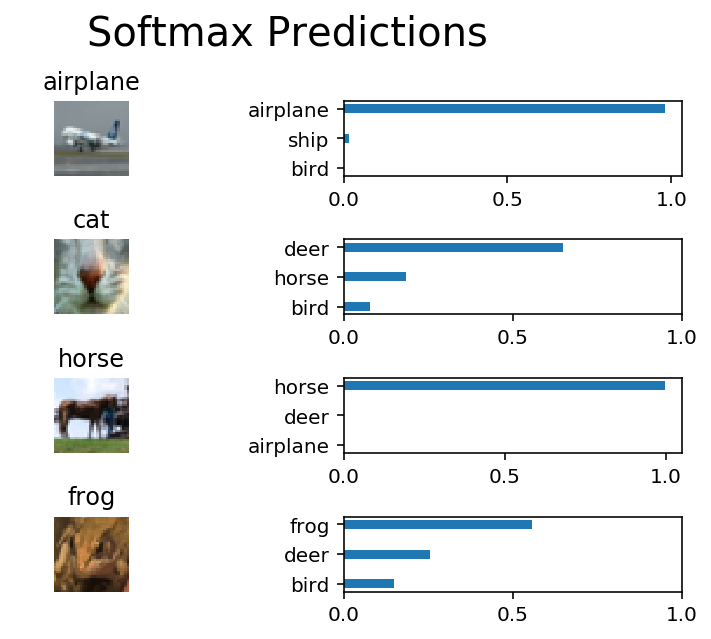

In [22]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for test_feature_batch, test_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: test_feature_batch, loaded_y: test_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()

## Why 50-80% Accuracy?
You might be wondering why you can't get an accuracy any higher. First things first, 50% isn't bad for a simple CNN.  Pure guessing would get you 10% accuracy. However, you might notice people are getting scores [well above 80%](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130).  That's because we haven't taught you all there is to know about neural networks. We still need to cover a few more techniques.
## Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook.  Save the notebook file as "dlnd_image_classification.ipynb" and save it as a HTML file under "File" -> "Download as".  Include the "helper.py" and "problem_unittests.py" files in your submission.